<a href="https://colab.research.google.com/github/Shauryagulati/Case-Study/blob/master/The_Manipulators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# module for performing test train split
from sklearn.model_selection import train_test_split
# Module for feture scaling
from sklearn.preprocessing import MinMaxScaler
# statmodel linear regression
import statsmodels.api as sm
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Clone the entire repo.
!git clone -l -s git://github.com/Shauryagulati/Case-Study-3.git cloned-repo
%cd cloned-repo
!ls

In [0]:
car_data = pd.read_csv("/content/cloned-repo/CarPrice.csv")

In [0]:
car_data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [0]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [0]:
car_data.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [0]:
car_data.shape

(205, 26)

Thus, there are 205 rows and 26 columns in the dataframe.

In [0]:
car_data.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

The Dataset is clean, thus having no missing values.

In [0]:
# Dropping Duplicates if any
car_data=car_data.drop_duplicates()

In [0]:
#we can drop the car_ID variable which is not relevent for the price modeling
car_data.drop('car_ID',axis=1,inplace=True)

We only need the Company name for building our model. So, We will be getting Company name from the CarName and saving it as a new CompanyName field. 

# DATA UNDERSTANDING and CORRECTION

In [0]:
# sns.pairplot(car_data)
# plt.show()

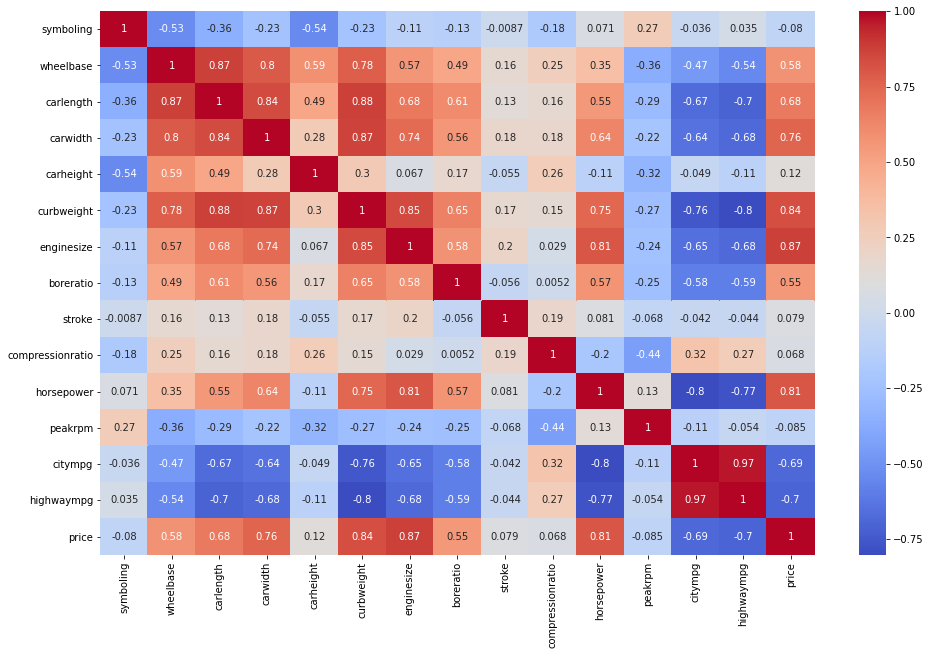

In [0]:
plt.figure(figsize = (16, 10))
cor=car_data.corr()
sns.heatmap(cor, annot = True, cmap="coolwarm")
plt.show()

From this, we can have a general sense of which features are related to price. We can spot some features which has some kind of positive relationships going on with the dependent price variable like,
-  wheelbase,
-  carlength,
-  carwidth,
-  curbweight,
-  enginesize,
-  boreratio,
-  horsepower.<br>
However, there are also a few variables showing a negative relationship with price variable like,
-  citympg,
-  highwaympg.
<br>
<br>We will further explore these. For now we know there is some relationship going on with the price variable.

Also, at this state itself we see there is some obvious multicollinearity going on between predictor variables,
<br>
-  carlength with wheelbase, carwidth, curbweight
-  curbweight with enginesize, carlength, carwidth, wheelbase
-  enginesize with horsepower, crubweight and dimestions of car
- highway and city mpg's are highly correlated with a pearson r cofficieant of 0.97. We might choose to drop anyone of these.<br>
<br> We also plot some negative corelation among varaibles,
- crubweight,horsepower with the higway/city mpg's


Symboling is a categorical variable which has been treeted as a numeric int64 type variable. Let's convert the symboling variable.
<br> Here Symboling is the assigned insurance risk rating,A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.<br>
Let's make the category clear by classifying based on risk
-  -ve symboling as __safe__
-  0, 1 as **moderate**
-  2,3 as **risky** 

In [0]:
car_data['symboling'] = car_data['symboling'].map({-2: 'safe',-1: 'safe',0: 'moderate',1: 'moderate',2: 'risky',3:'risky'})

In [0]:
car_data['car_company'] = car_data['CarName'].apply(lambda x: x.split( )[0])
car_data.drop('CarName',axis=1,inplace=True)

In [0]:
car_data['car_company'].unique()  

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [0]:
# Correcting the misspelled company names.
car_data['car_company'].replace('maxda','mazda',inplace=True)
car_data['car_company'].replace('Nissan','nissan',inplace=True)
car_data['car_company'].replace('porcshce','porsche',inplace=True)
car_data['car_company'].replace('toyouta','toyota',inplace=True)
car_data['car_company'].replace(['vokswagen','vw'],'volkswagen',inplace=True)

In [0]:
categorical_variables = list(car_data.columns[car_data.dtypes == 'object'])
categorical_variables

['symboling',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'car_company']

In [0]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    object 
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    object 
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

In [0]:
## Wonderful solution to show labels in bar plots - copied from https://stackoverflow.com/a/48372659 and edited
def showLabels(ax, d=None):
    plt.margins(0.2, 0.2)
    rects = ax.patches
    i = 0
    locs, labels = plt.xticks() 
    counts = {}
    if not d is None:
        for key, value in d.items():
            counts[str(key)] = value

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if d is None:
            label = "{:.1f}%".format(y_value)
        else:
            try:
                label = "{:.1f}%".format(y_value) + "\nof " + str(counts[str(labels[i].get_text())])
            except:
                label = "{:.1f}%".format(y_value)
        
        i = i+1

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [0]:
def plot_percentages(dataframe, var_list, sortbyindex=False):
# Plot the percentage of car's in the US market with respect to different car features
    plt.figure(figsize=(30, 27))
    for var in var_list:
      
        plt.subplot(3,4,var_list.index(var)+1)
        values = (dataframe[var].value_counts(normalize=True)*100)
        if sortbyindex:
                values = values.sort_index()
        ax = values.plot.bar(color=sns.color_palette('deep', 16))
        ax.set_ylabel('% in dataset', fontsize=16)
        ax.set_xlabel(var, fontsize=10)
        showLabels(ax)
def plot_cat(var_list):
#Function to plot a list of categorical variables together
    plt.figure(figsize=(20, 15))
    for var in var_list:
        plt.subplot(3,4,var_list.index(var)+1)
        sns.boxplot(x = var, y = 'price', data = car_data)
    plt.show()
def plot_dist(var_list):
#Function to plot the distribution plot of the numeric variable list
    plt.figure(figsize=(20, 15))
    for var in var_list:
        plt.subplot(3,5,var_list.index(var)+1)
        sns.distplot(car_data[var], bins=10)
    plt.show()
def fit_LRM(X_train):
#Function to fit the linear regression model from the statmodel package
# Creating X_train dataframe with the selected variables
    # Adding a constant variable  
    X_train = sm.add_constant(X_train)
    lm = sm.OLS(y_train,X_train).fit() 
    print(lm.summary())
    return lm
def getVIF(X_train):
    #X_train = df.drop(['const'], axis=1)
    # Calculate the VIFs for the new model
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

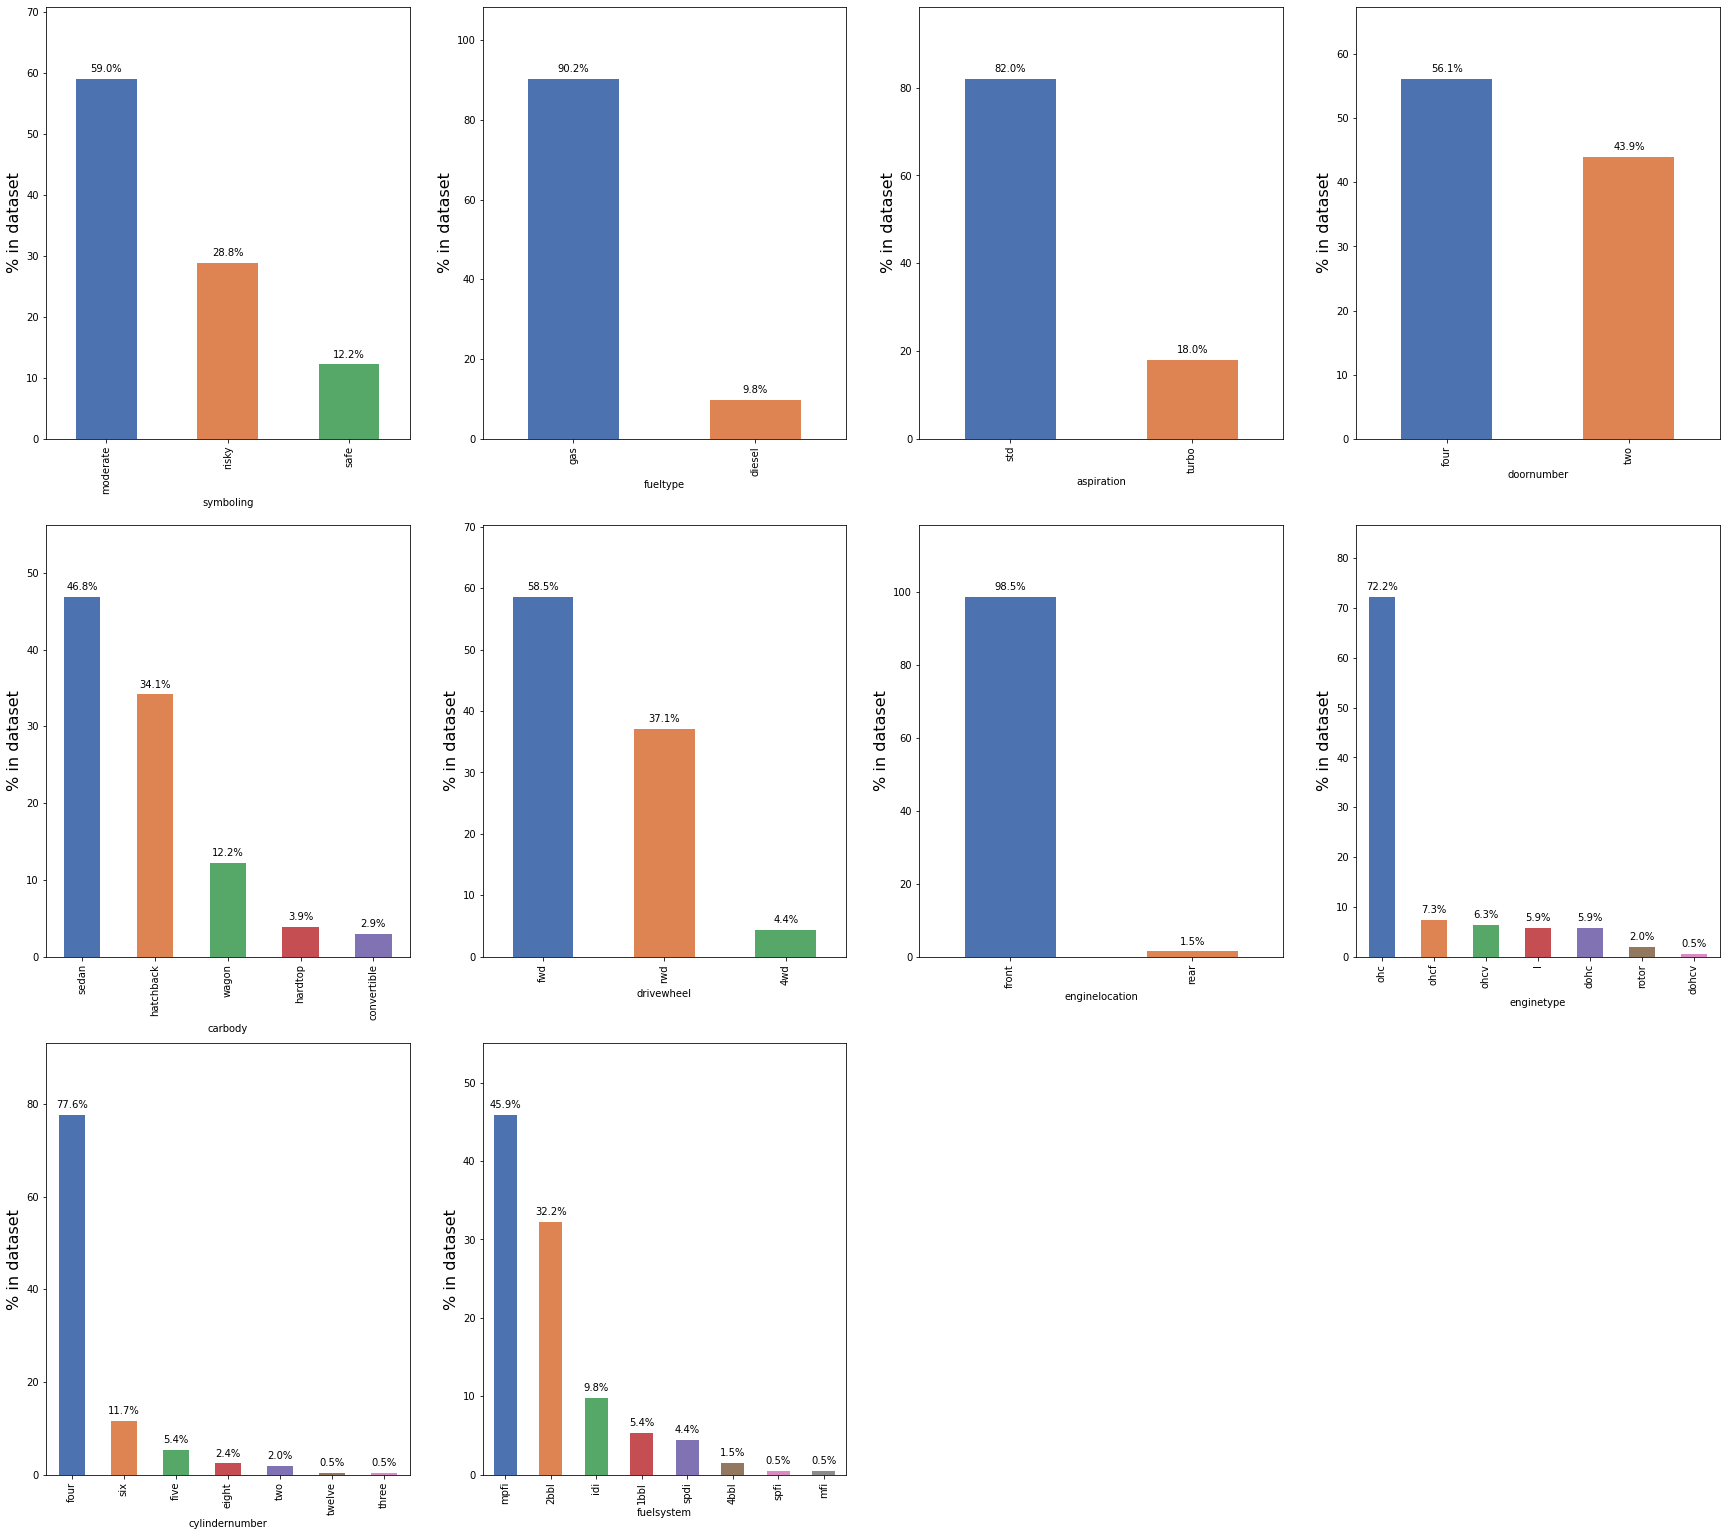

In [0]:
plot_percentages(car_data,categorical_variables[:-1])

We can identify the some of the car **features that are predominant** in the US Automobile Market, Geely Automotives can consider these facts to full fill the market dominant needs and make the needed changes to their manufacturing line.
These features are:
-  **symboling:** moderate (0,1)
-  **Carbody:** Sedan
-  **fueltype:** gas
-  **aspiration:** standard
-  **doornumbers:** four
-  **drivewheel:** forward
-  **engine location:** front
-  **engine type:** ohc
-  **cylinderNumber:** four
-  **fuelSystem**: mpfi


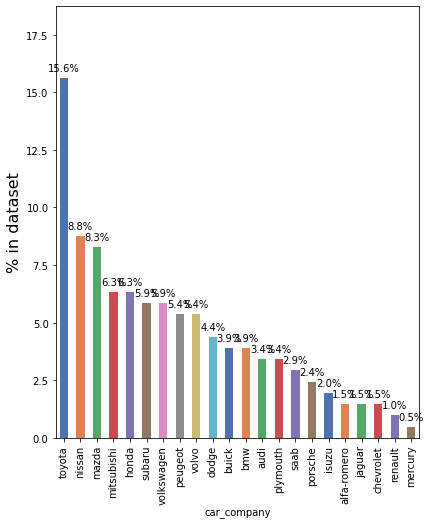

In [0]:
%matplotlib inline
plot_percentages(car_data,[categorical_variables[-1]])

We can see that **TOYOTA** Is the most popular company in America at 15.6%
Followed by **Nissan** and  **Mazda**

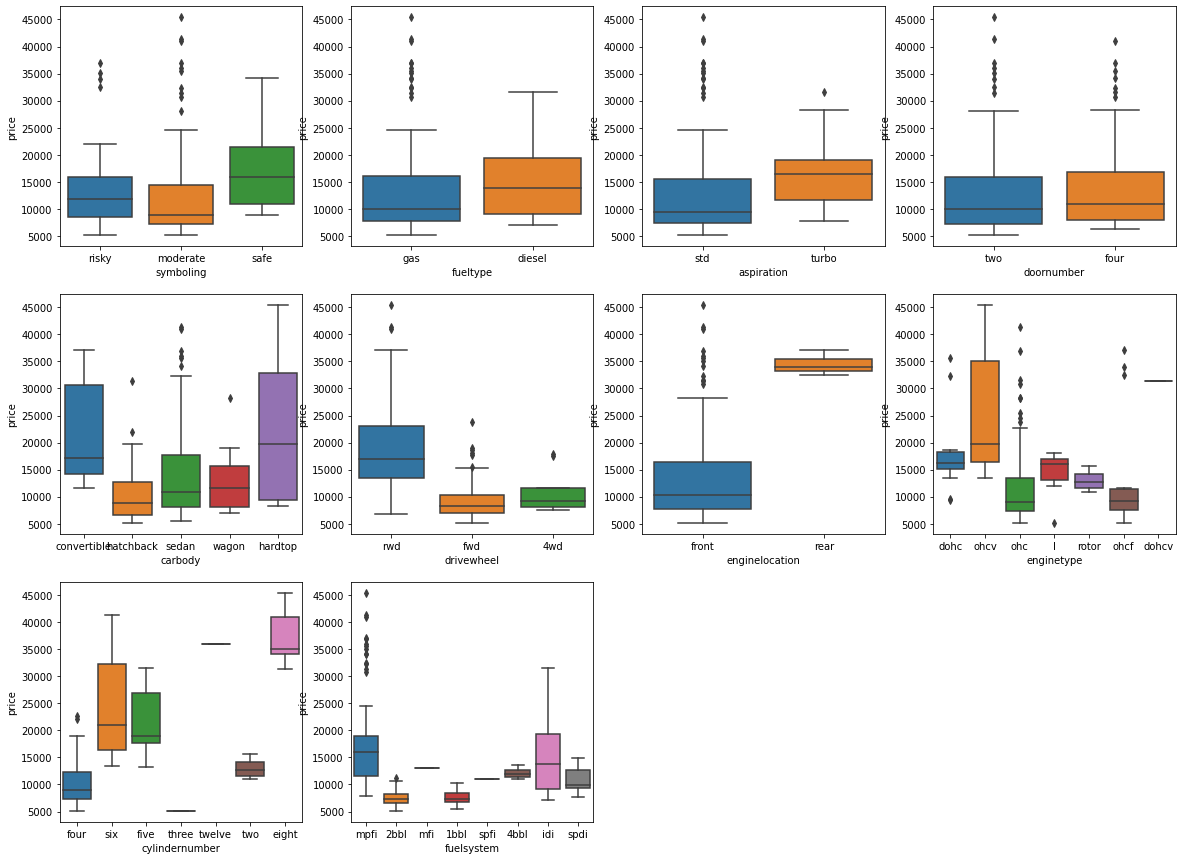

In [0]:
# ploting all variables excluding car_company against the output variable
plot_cat(categorical_variables[:-1]) 

Here we see there are multiple outliers in the variables

SO we will need to treat them before moving on to the model.

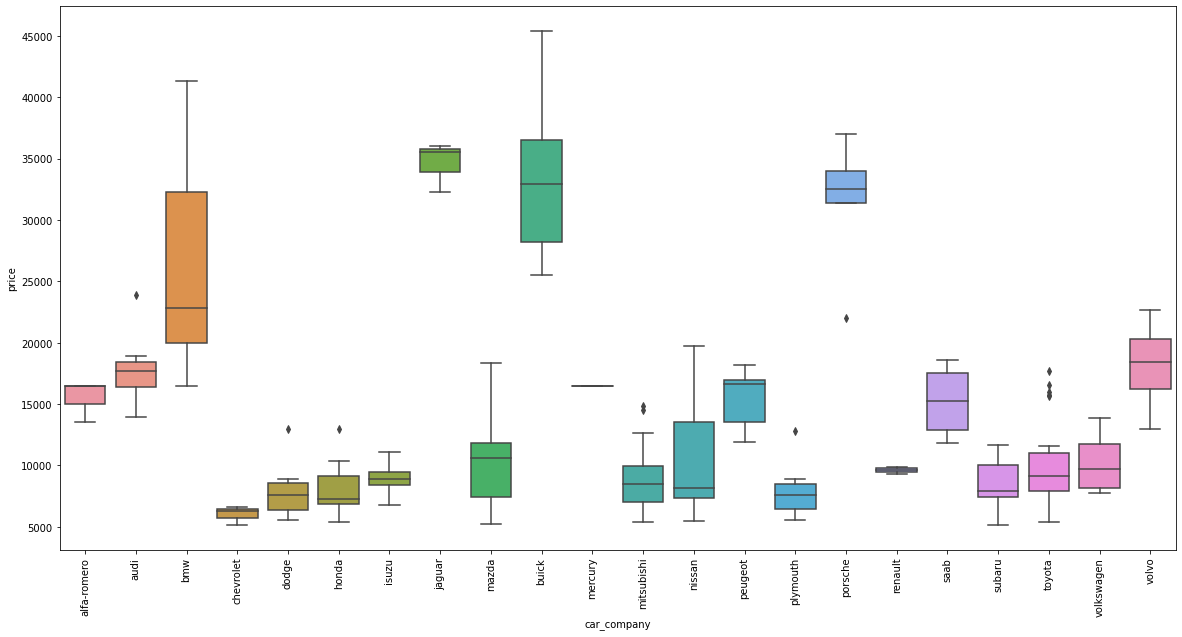

Average US car price:  13276.710570731706
car_company
jaguar     34600.000000
buick      33647.000000
porsche    31400.500000
bmw        26118.750000
volvo      18063.181818
Name: price, dtype: float64


In [0]:
plt.figure(figsize=(20,10))
sns.boxplot(x = categorical_variables[-1], y = 'price', data = car_data)
plt.xticks(rotation=90)
plt.show()
print('Average US car price: ',car_data['price'].mean())
print(car_data.groupby('car_company').price.mean().sort_values(ascending=False).head())

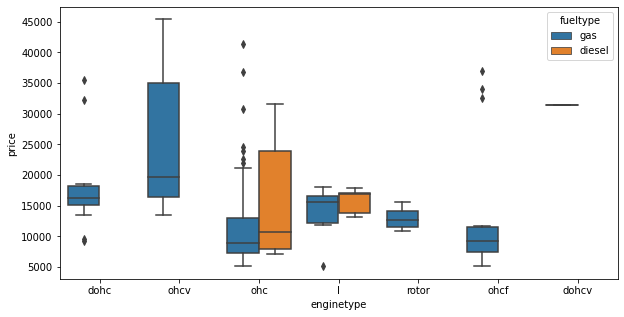

In [0]:
plt.figure(figsize=(10,5))
sns.boxplot(x='enginetype', y='price', hue = 'fueltype', data=car_data)
plt.show()

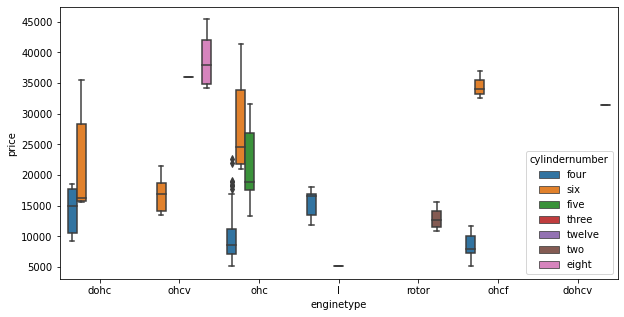

In [0]:
plt.figure(figsize=(10,5))
sns.boxplot(x='enginetype', y='price', hue = 'cylindernumber', data=car_data)
plt.show()

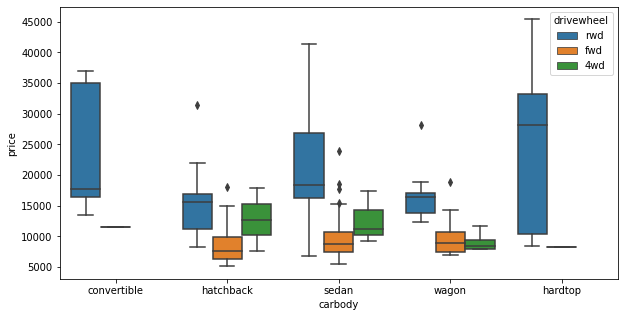

In [0]:
plt.figure(figsize=(10,5))
sns.boxplot(x='carbody', y='price', hue = 'drivewheel', data=car_data)
plt.show()

# OUTLIERS TREATMENT

In [0]:
numeric_variables = list(car_data.columns[car_data.dtypes != 'object'])
print(numeric_variables)

['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


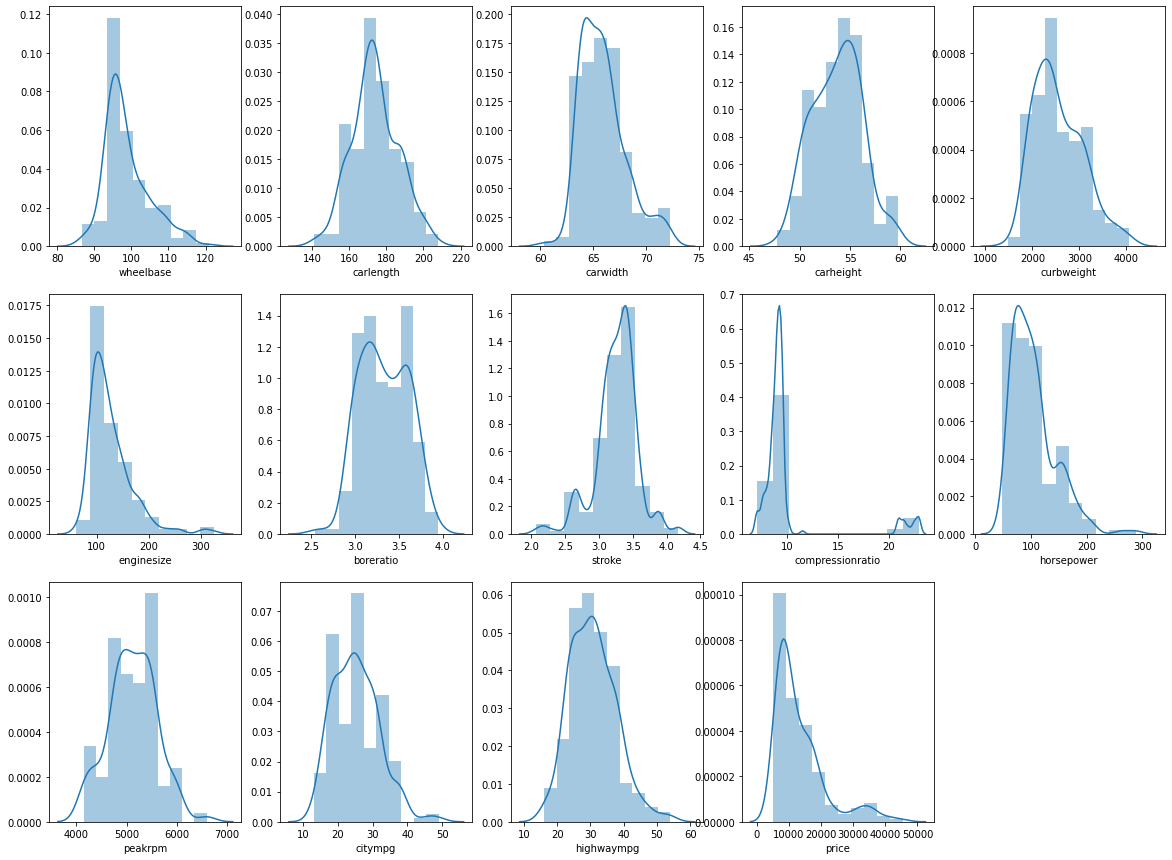

In [0]:
plt.figure(figsize=(20, 15))
for var in numeric_variables:
    plt.subplot(3,5,numeric_variables.index(var)+1)
    sns.distplot(car_data[var], bins=10)
plt.show()

We see Compression ratio , price, horsepower have skewed distribution.

In [0]:
print(car_data[['horsepower','curbweight','enginesize']].quantile([0.01, .96]))
print(car_data[['compressionratio']].quantile([0.01, .90]))

      horsepower  curbweight  enginesize
0.01       52.12     1819.72        70.0
0.96      182.00     3657.80       209.0
      compressionratio
0.01              7.00
0.90             10.94


From each of these variables we take out he value lying farther than 90% for compression due to fact it is most skewed and 95% for those which are slighly less skewed.

In [0]:
car_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'car_company'],
      dtype='object')

In [0]:
# Outilers in price of cars
car_data['horsepower'][np.abs(car_data['horsepower'] > 182.00)]= 182.00
car_data['horsepower'][np.abs(car_data['horsepower'] > 3657.80)]= 3657.80
car_data['enginesize'][np.abs(car_data['enginesize'] > 209.00)]= 209.00
car_data['compressionratio'][np.abs(car_data['compressionratio'] > 10.94)]= 10.94

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

We keep the car's data for which the price is less than 3 standard deviation.

In [0]:
 car_data= car_data[np.abs(car_data.price-car_data.price.mean()) <= (3*car_data.price.std())]

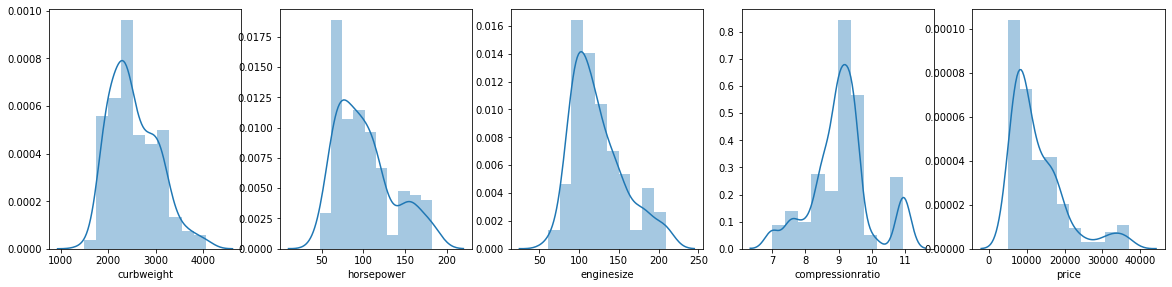

In [0]:
plot_dist(['curbweight','horsepower','enginesize','compressionratio','price'])

We can see that the values that we tweaked are now far less skewed.

## Creating new variables

This will help in removing coorelation

In [0]:
# Creating new variable carLWratio
car_data['carLWratio'] = car_data.carlength/car_data.carwidth
# Creating new variable carWHratio
car_data['carWHratio'] = car_data.carwidth/car_data.carheight
# Creating new variable PWratio
car_data['PWratio'] = car_data.horsepower/car_data.curbweight
# Creating new variable HCmpgratio
car_data['HCmpgratio'] = car_data.highwaympg/car_data.citympg
## droping the orignal variables
car_data.drop(['carlength','carwidth','carheight','highwaympg','citympg'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Since we saw that the company brand value also is determinig the pricing of the car. Let's create a company_segment categorical variable which would suggest, under which segment tier does the car_company comes under.<br>
We will segment the car companies based on the mean company price as 
-  __lowtier__ if company mean price is below 10,000
-  __midtier__ if company mean price is above 10,000 and below 20,000
-  __hightier__ if company mean price is above 20,000

In [0]:
car_data.groupby('car_company').price.mean().sort_values(ascending=False)

car_company
jaguar         34600.000000
porsche        31400.500000
buick          30469.333333
bmw            23947.857143
volvo          18063.181818
audi           17859.166714
mercury        16503.000000
alfa-romero    15498.333333
peugeot        15489.090909
saab           15223.333333
mazda          10652.882353
nissan         10415.666667
volkswagen     10077.500000
toyota          9885.812500
renault         9595.000000
mitsubishi      9239.769231
isuzu           8916.500000
subaru          8541.250000
honda           8184.692308
plymouth        7963.428571
dodge           7875.444444
chevrolet       6007.000000
Name: price, dtype: float64

In [0]:
company_segment_dict = {
    'cheverolet' : 'lowtier',
    'dodge' : 'lowtier',
    'plymouth' : 'lowtier',
    'honda' : 'lowtier',
    'subaru' : 'lowtier',
    'isuzu' : 'lowtier',
    'mitsubishi' : 'lowtier',
    'renault' : 'lowtier',
    'toyota' : 'lowtier',
    'volkswagen' : 'midtier',
    'nissan' : 'midtier',
    'mazda' : 'midtier',
    'saab' : 'midtier',
    'peugeot' : 'midtier',
    'alfa-romero' : 'midtier',
    'mercury' : 'midtier',
    'audi' : 'midtier',
    'volvo' : 'midtier',
    'bmw' : 'hightier',
    'buick' : 'hightier',
    'porsche' : 'hightier',
    'jaguar' : 'hightier',
    }
car_data['company_segment'] = car_data['car_company'].map(company_segment_dict)
# Dropping the orignal car_company variable
car_data.drop('car_company',axis=1,inplace=True)
car_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price,carLWratio,carWHratio,PWratio,HCmpgratio,company_segment
0,risky,gas,std,two,convertible,rwd,front,88.6,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,13495.0,2.633385,1.313525,0.043564,1.285714,midtier
1,risky,gas,std,two,convertible,rwd,front,88.6,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,16500.0,2.633385,1.313525,0.043564,1.285714,midtier
2,moderate,gas,std,two,hatchback,rwd,front,94.5,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,16500.0,2.613740,1.250000,0.054552,1.368421,midtier
3,risky,gas,std,four,sedan,fwd,front,99.8,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,13950.0,2.667674,1.219153,0.043646,1.250000,midtier
4,risky,gas,std,four,sedan,4wd,front,99.4,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,17450.0,2.659639,1.222836,0.040722,1.222222,midtier


In [0]:
car_data.groupby('company_segment').price.mean()

company_segment
hightier    29107.309524
lowtier      8987.369565
midtier     13231.839151
Name: price, dtype: float64

SO now we can focus on converting the categorical values to some numerical form.

In [0]:
car_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'price', 'carLWratio',
       'carWHratio', 'PWratio', 'HCmpgratio', 'company_segment'],
      dtype='object')

In [0]:
# Converting categorical variables with two levels to either 1 or 0
car_data['fueltype'] = car_data['fueltype'].map({'gas': 1, 'diesel': 0})
car_data['aspiration'] = car_data['aspiration'].map({'std': 1, 'turbo': 0})
car_data['doornumber'] = car_data['doornumber'].map({'two': 1, 'four': 0})
car_data['enginelocation'] = car_data['enginelocation'].map({'front': 1, 'rear': 0})
car_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price,carLWratio,carWHratio,PWratio,HCmpgratio,company_segment
0,risky,1,1,1,convertible,rwd,1,88.6,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,13495.0,2.633385,1.313525,0.043564,1.285714,midtier
1,risky,1,1,1,convertible,rwd,1,88.6,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,16500.0,2.633385,1.313525,0.043564,1.285714,midtier
2,moderate,1,1,1,hatchback,rwd,1,94.5,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,16500.0,2.613740,1.250000,0.054552,1.368421,midtier
3,risky,1,1,0,sedan,fwd,1,99.8,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,13950.0,2.667674,1.219153,0.043646,1.250000,midtier
4,risky,1,1,0,sedan,4wd,1,99.4,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,17450.0,2.659639,1.222836,0.040722,1.222222,midtier


In [0]:
# Creating dummy variables
df = pd.get_dummies(car_data)
# Droping 1 dummy variable and Keeping n-1 varaibles for each feature 
df.drop(['symboling_risky',
         'carbody_hatchback',
         'drivewheel_4wd',
         'enginetype_l',
         'cylindernumber_three',
         'fuelsystem_1bbl',
         'company_segment_lowtier'],axis=1,inplace=True)
df.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'price', 'carLWratio', 'carWHratio', 'PWratio',
       'HCmpgratio', 'symboling_moderate', 'symboling_safe',
       'carbody_convertible', 'carbody_hardtop', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohc',
       'enginetype_dohcv', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'cylindernumber_eight',
       'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_twelve', 'cylindernumber_two', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi',
       'company_segment_hightier', 'company_segment_midtier'],
      dtype='object')

# Spliting the data

In [0]:
from sklearn.model_selection import train_test_split

# Splitting the avilable data into training and testing set.

df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [0]:
from sklearn.preprocessing import MinMaxScaler
# Using MinMaxScaler to scale all the numeric variables in the same scale between 0 and 1.
scaler = MinMaxScaler()

In [0]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['horsepower','wheelbase','curbweight', 'enginesize', 'boreratio','stroke','compressionratio','peakrpm','price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
  
df_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,fueltype,aspiration,doornumber,enginelocation,wheelbase,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,price,carLWratio,carWHratio,PWratio,HCmpgratio,symboling_moderate,symboling_safe,carbody_convertible,carbody_hardtop,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginetype_dohc,enginetype_dohcv,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,company_segment_hightier,company_segment_midtier
1,1,1,1,1,0.068966,0.411171,0.466216,0.664286,0.290476,0.507614,0.470149,0.346939,0.358353,2.633385,1.313525,0.043564,1.285714,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
165,1,1,1,1,0.272414,0.301396,0.250000,0.500000,0.480952,0.609137,0.477612,1.000000,0.131604,2.635937,1.216730,0.049448,1.115385,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
197,1,1,0,1,0.610345,0.602793,0.540541,0.885714,0.514286,0.634518,0.492537,0.510204,0.358825,2.809524,1.168696,0.037475,1.166667,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
169,1,1,1,1,0.406897,0.412335,0.574324,0.771429,0.680952,0.583756,0.507463,0.265306,0.153359,2.685976,1.261538,0.045472,1.250000,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
190,1,1,1,1,0.272414,0.284329,0.324324,0.464286,0.633333,0.380711,0.313433,0.551020,0.153076,2.589062,1.245136,0.040522,1.208333,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [0]:
df_train.describe().shape

(8, 46)

In [0]:
y_train = df_train.pop('price')
X_train = df_train

# RFE

In [0]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [0]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE and selecting 15 features best describing the price of cars
rfe = rfe.fit(X_train, y_train)

In [0]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('fueltype', False, 15),
 ('aspiration', False, 9),
 ('doornumber', False, 24),
 ('enginelocation', True, 1),
 ('wheelbase', True, 1),
 ('curbweight', False, 30),
 ('enginesize', False, 8),
 ('boreratio', False, 6),
 ('stroke', True, 1),
 ('compressionratio', False, 11),
 ('horsepower', True, 1),
 ('peakrpm', True, 1),
 ('carLWratio', True, 1),
 ('carWHratio', True, 1),
 ('PWratio', True, 1),
 ('HCmpgratio', False, 19),
 ('symboling_moderate', False, 28),
 ('symboling_safe', False, 27),
 ('carbody_convertible', True, 1),
 ('carbody_hardtop', False, 22),
 ('carbody_sedan', False, 17),
 ('carbody_wagon', False, 25),
 ('drivewheel_fwd', False, 29),
 ('drivewheel_rwd', False, 26),
 ('enginetype_dohc', False, 3),
 ('enginetype_dohcv', False, 2),
 ('enginetype_ohc', True, 1),
 ('enginetype_ohcf', False, 4),
 ('enginetype_ohcv', False, 12),
 ('enginetype_rotor', False, 16),
 ('cylindernumber_eight', False, 13),
 ('cylindernumber_five', True, 1),
 ('cylindernumber_four', True, 1),
 ('cylinder

In [0]:
col = X_train.columns[rfe.support_]
col

Index(['enginelocation', 'wheelbase', 'stroke', 'horsepower', 'peakrpm',
       'carLWratio', 'carWHratio', 'PWratio', 'carbody_convertible',
       'enginetype_ohc', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'fuelsystem_4bbl', 'company_segment_hightier'],
      dtype='object')

In [0]:
X_train.columns[~rfe.support_]

Index(['fueltype', 'aspiration', 'doornumber', 'curbweight', 'enginesize',
       'boreratio', 'compressionratio', 'HCmpgratio', 'symboling_moderate',
       'symboling_safe', 'carbody_hardtop', 'carbody_sedan', 'carbody_wagon',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohc',
       'enginetype_dohcv', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_eight', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'fuelsystem_mpfi', 'fuelsystem_spdi',
       'fuelsystem_spfi', 'company_segment_midtier'],
      dtype='object')

## Building model using Statsmodel

In [0]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [0]:
lm=fit_LRM(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     173.0
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           6.66e-76
Time:                        11:14:54   Log-Likelihood:                 225.25
No. Observations:                 141   AIC:                            -418.5
Df Residuals:                     125   BIC:                            -371.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

- fuelsystem_4bbl has a p-value > 0.05. Meaning this variable is not having enough impact. Let's drop it.

In [0]:
X_train1 = X_train_rfe.drop('fuelsystem_4bbl', axis=1)

In [0]:
lm1=fit_LRM(X_train1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     184.9
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           8.94e-77
Time:                        11:14:54   Log-Likelihood:                 224.55
No. Observations:                 141   AIC:                            -419.1
Df Residuals:                     126   BIC:                            -374.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

- cylindernumber_five has a p-value > 0.05. Meaning this variable is not having enough impact. Let's drop it.

In [0]:
X_train2 = X_train1.drop('cylindernumber_five', axis=1)

In [0]:
lm2=fit_LRM(X_train2)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     198.3
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           1.28e-77
Time:                        11:14:54   Log-Likelihood:                 223.74
No. Observations:                 141   AIC:                            -419.5
Df Residuals:                     127   BIC:                            -378.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

- cylindernumber_six has a p-value > 0.05. Meaning this variable is not having enough impact. Let's drop it.

In [0]:
X_train3 = X_train2.drop('cylindernumber_six', axis=1)

In [0]:
lm3=fit_LRM(X_train3)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     215.5
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           1.14e-78
Time:                        11:14:54   Log-Likelihood:                 223.41
No. Observations:                 141   AIC:                            -420.8
Df Residuals:                     128   BIC:                            -382.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

-  carLWratio is having a high VIF and is highly correlated to wheelbase and slightly with horsepower. Let's remove this.

In [0]:
X_train4 = X_train3.drop('carLWratio', axis=1)

In [0]:
lm4=fit_LRM(X_train4)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     231.6
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           2.88e-79
Time:                        11:14:55   Log-Likelihood:                 221.89
No. Observations:                 141   AIC:                            -419.8
Df Residuals:                     129   BIC:                            -384.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [0]:
getVIF(X_train4)

,Features,VIF
5,carWHratio,255.18
6,PWratio,207.14
0,enginelocation,110.55
3,horsepower,37.22
2,stroke,22.08
1,wheelbase,14.98
9,cylindernumber_four,8.95
4,peakrpm,8.18
8,enginetype_ohc,6.04
10,company_segment_hightier,2.34


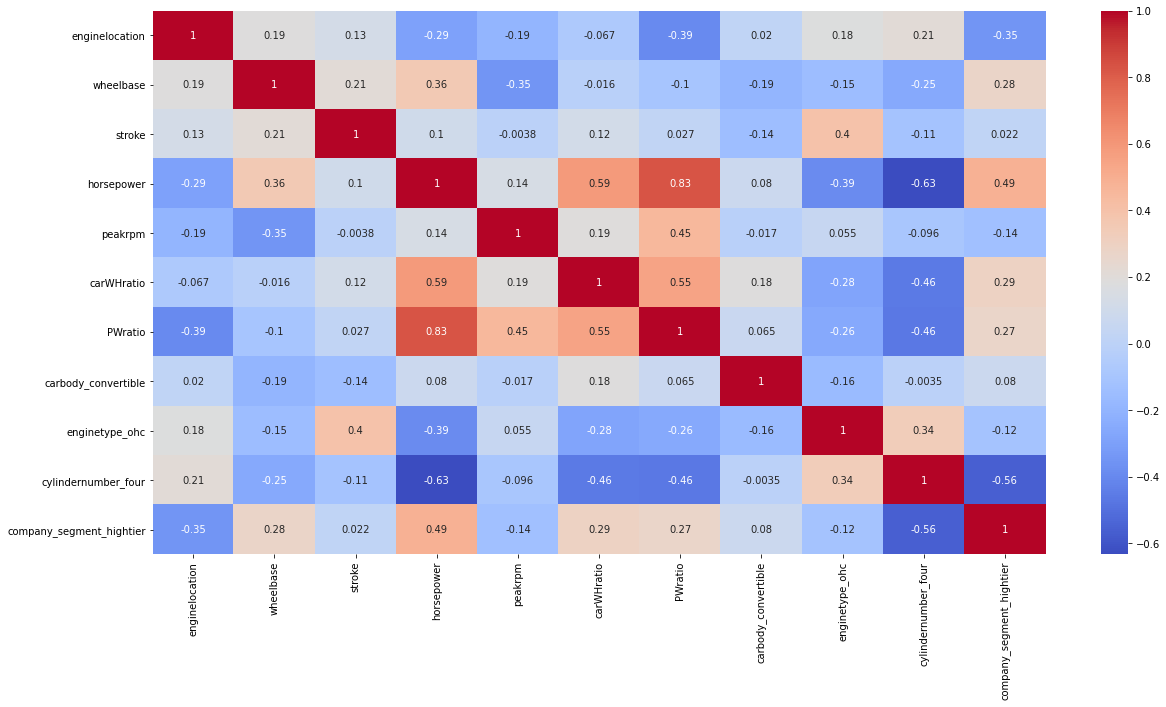

In [0]:
plt.figure(figsize = (20,10))  
sns.heatmap(X_train4.corr(),annot = True,cmap="coolwarm")


-  removing carLWratio had no impact on the Adj. R-Squared.
- PWratio is having the highest VIF and is strongly corelated with horsepower, carWHratio and peakrpm. Let's remove this

In [0]:
X_train5 = X_train4.drop('PWratio', axis=1)

In [0]:

lm5=fit_LRM(X_train5)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     175.7
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           2.00e-70
Time:                        11:14:56   Log-Likelihood:                 196.68
No. Observations:                 141   AIC:                            -371.4
Df Residuals:                     130   BIC:                            -338.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [0]:
getVIF(X_train5)

,Features,VIF
5,carWHratio,150.82
0,enginelocation,110.51
2,stroke,22.01
1,wheelbase,10.24
3,horsepower,9.62
8,cylindernumber_four,8.45
4,peakrpm,6.82
7,enginetype_ohc,5.93
9,company_segment_hightier,2.31
6,carbody_convertible,1.20


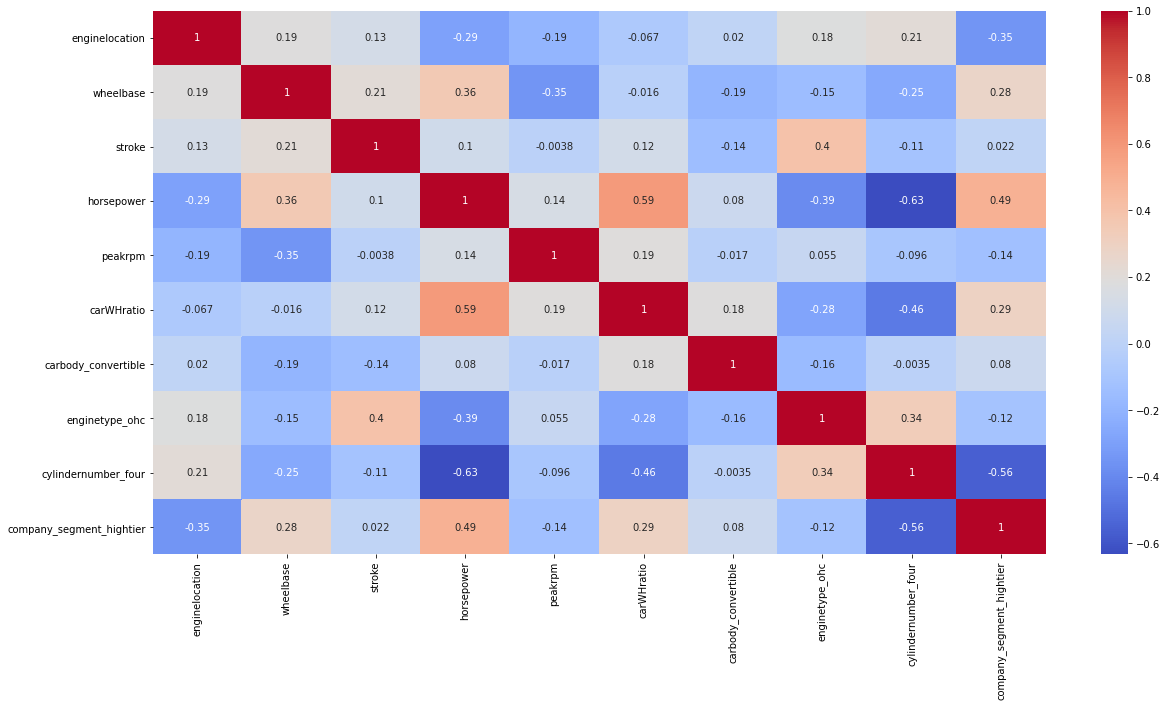

In [0]:
plt.figure(figsize = (20,10))  
sns.heatmap(X_train5.corr(),annot = True,cmap="coolwarm")

-  removing PWratio reduced the Adj. R-Squared to 0.926(not much)
-  peakrpm is having high p-value. Let's remove this

In [0]:
X_train6 = X_train5.drop('peakrpm', axis=1)

In [0]:
lm6=fit_LRM(X_train6)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     196.6
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           1.40e-71
Time:                        11:14:56   Log-Likelihood:                 196.67
No. Observations:                 141   AIC:                            -373.3
Df Residuals:                     131   BIC:                            -343.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

-  enginetype_ohc is having p-value > 0.05, making it insignificant in the model. Let's remove this.

In [0]:
X_train7 = X_train6.drop('enginetype_ohc', axis=1)

In [0]:
lm7=fit_LRM(X_train7)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     217.7
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           3.82e-72
Time:                        11:14:56   Log-Likelihood:                 195.12
No. Observations:                 141   AIC:                            -372.2
Df Residuals:                     132   BIC:                            -345.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

-  stroke is having p-value > 0.05 . Let's remove this.

In [0]:
X_train8 = X_train7.drop('stroke', axis=1)

In [0]:
lm8=fit_LRM(X_train8)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     247.0
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           5.81e-73
Time:                        11:14:56   Log-Likelihood:                 194.15
No. Observations:                 141   AIC:                            -372.3
Df Residuals:                     133   BIC:                            -348.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [0]:
getVIF(X_train8)

,Features,VIF
3,carWHratio,120.97
0,enginelocation,104.79
2,horsepower,8.96
1,wheelbase,8.60
5,cylindernumber_four,7.59
6,company_segment_hightier,1.96
4,carbody_convertible,1.14


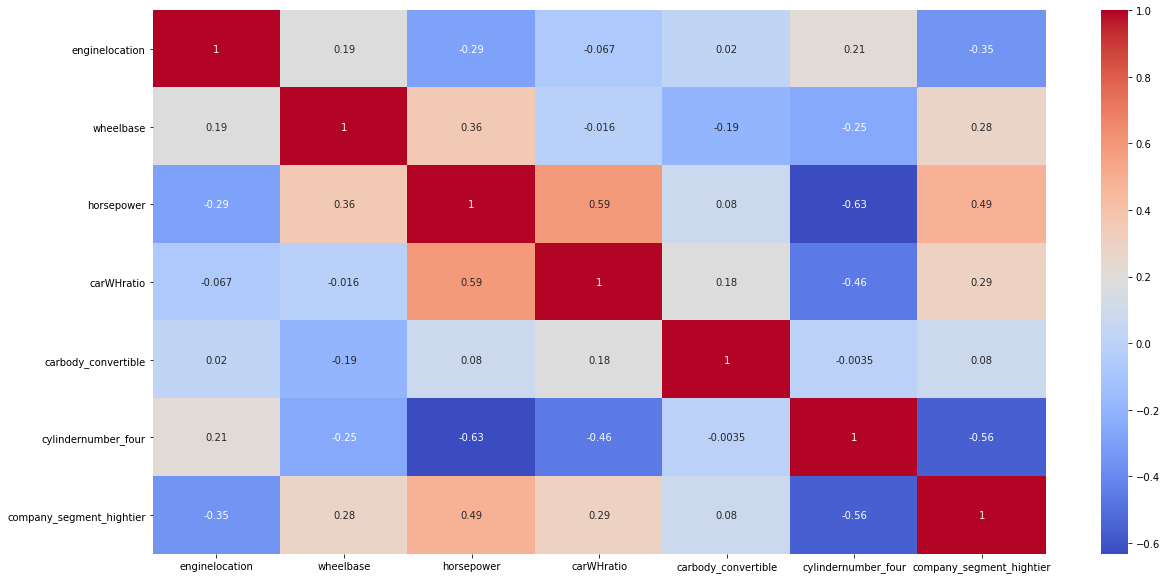

In [0]:
plt.figure(figsize = (20,10))  
sns.heatmap(X_train8.corr(),annot = True,cmap="coolwarm")
plt.show()

-  enginelocation is having the highest VIF. Let's remove this.

In [0]:
X_train9 = X_train8.drop('enginelocation', axis=1)

In [0]:
lm9=fit_LRM(X_train9)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     231.4
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           3.82e-68
Time:                        11:14:57   Log-Likelihood:                 179.41
No. Observations:                 141   AIC:                            -344.8
Df Residuals:                     134   BIC:                            -324.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [0]:
getVIF(X_train9)

,Features,VIF
2,carWHratio,19.60
4,cylindernumber_four,7.59
1,horsepower,7.33
0,wheelbase,6.41
5,company_segment_hightier,1.75
3,carbody_convertible,1.12


[]

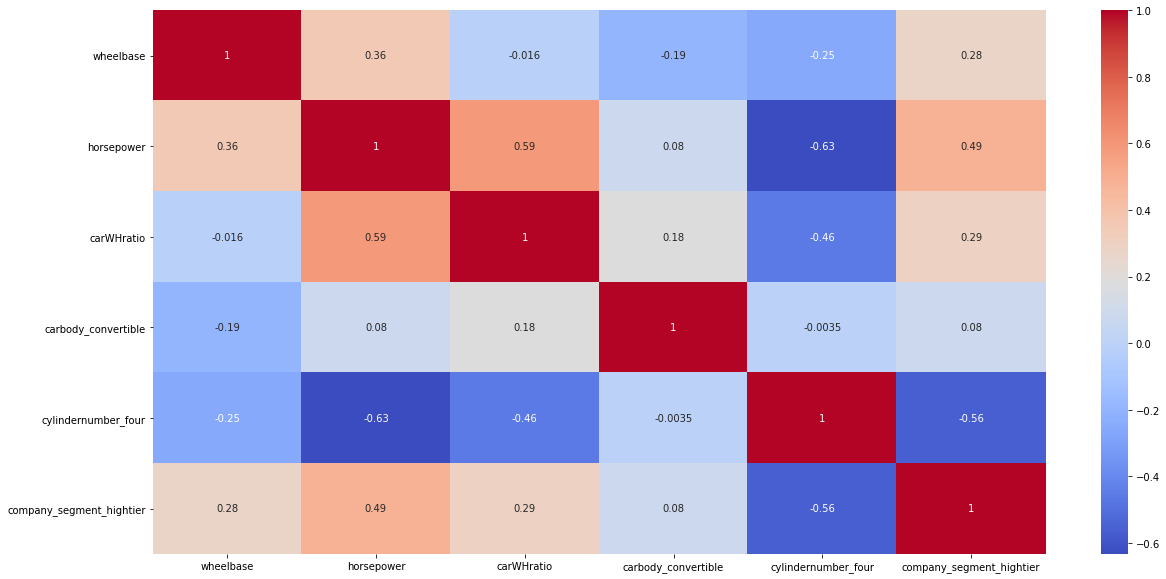

In [0]:
plt.figure(figsize = (20,10))  
sns.heatmap(X_train9.corr(),annot = True,cmap="coolwarm")
plt.plot()

-  removing enginelocation lowers the Adj. R-Squared to  0.908. Still a significant fit.
-  Horsepower is more bussiness significant variable that carWHratio which also has a high VIF. carWHratio is correlated with horsepower. Let's remove carHWratio.

In [0]:
X_train10 = X_train9.drop('carWHratio', axis=1)
X_train10 = sm.add_constant(X_train10)
lm10 = sm.OLS(y_train,X_train10).fit() 
print(lm10.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     273.2
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           9.11e-69
Time:                        11:14:58   Log-Likelihood:                 177.91
No. Observations:                 141   AIC:                            -343.8
Df Residuals:                     135   BIC:                            -326.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [0]:
getVIF(X_train10)

,Features,VIF
0,const,19.89
4,cylindernumber_four,1.95
2,horsepower,1.89
5,company_segment_hightier,1.56
1,wheelbase,1.24
3,carbody_convertible,1.08


All the independent variable have considerably low VIF and the **Adj. R-Squared is 0.907** which is quite a significant fit. We will conclude with these variables as the final model predictor variables.

# Cross Checking the Train data

In [0]:
y_train_price = lm10.predict(X_train10)

Text(0.5, 0, 'Errors')

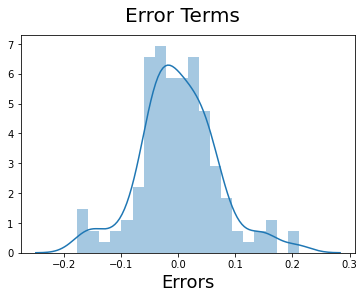

In [0]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

The train data has now become a good enough normal distrubution to apply linear models. Because the Linearn models have an assumption that the data is normally distributted.

So we had to make it as Close to a normal distributiona as we could.

## Testing data a bit

In [0]:
y_test = df_test.pop('price')
X_test = df_test

In [0]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_train10= X_train10.drop(['const'], axis=1)
X_test_new = X_test[X_train10.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [0]:
# Making predictions
y_pred = lm10.predict(X_test_new)

## Model Evalutaion

Text(0, 0.5, 'y_pred')

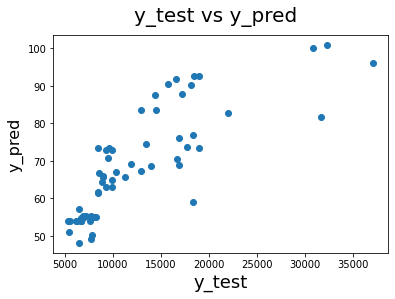

In [0]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

y_test VS y_pred is observed to be almost linear with some variataion occuring. Overall, it is a pretty linear spread.

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Model RMSE:',rmse)

from sklearn.metrics import r2_score
r2=r2_score(y_test, y_pred)
print('Model r2_score:',r2)

Model RMSE: 0.0673924212933167
Model r2_score: 0.9056388935908385


Overall we have a decent model, but we also acknowledge that we could do better. 

**Suggestions:**<br>


The chinese company  Geely Automotives entering the US market should consider the below listed points,

-  **Average US car price:**  13000 USD(approx).
For profitability and effective pricing of cars in this new market, the model's price predictors variables have to be regulated and balanced effectively to meet certain price levels and gain an edge over the other competitors.<br>
<br>
Also, keeping into account the predominating or the popular factors of a car in US market will give a better understanding of the needs and requirment of the citizens of USA.
-  **symboling:** moderate (0,1)
-  **Carbody:** Sedan
-  **fueltype:** gas
-  **aspiration:** standard
-  **doornumbers:** four
-  **drivewheel:** forward
-  **engine location:** front
-  **engine type:** ohc
-  **cylinderNumber:** four
-  **fuelSystem**: mpfi

This can be used to make the appropriate changes in design, features and the price offered to the customer.